# Exploratory Data Analysis

The goal of this step is to get keys insights about data, helping to better understand the data and build a better model

###### Questions to Answer
1. Which words are more important to separate clickbait from good article
2. Is the length of the headline or the content important for headline detection
3. Are question more clickbait than affirmative sentences
4. What are the key pattern describing clikbait (name in the headline, club name, action verb)
5.

### Import librairies and configurations

In [479]:
import pandas as pd
import numpy as np
import re
import string
import spacy
import cleantext as ct


import matplotlib.pyplot as plt
import plotly.express as px
from wordcloud import WordCloud

from nltk.stem.snowball import SnowballStemmer

from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer

import pickle

In [452]:
data_folder = '../../data'
model_folder = '../../models'

fr = spacy.load('fr_core_news_sm')
stopwords = fr.Defaults.stop_words

stemmer = SnowballStemmer(language='french')

RANDOM_STATE = 77

### Load data

In [295]:
data = pd.read_csv(f'{data_folder}/interim/dataset_01.csv')
print(f'Data shape {data.shape}')

data.sample(5)

Data shape (30000, 13)


,date,content,renderedContent,replyCount,retweetCount,likeCount,quoteCount,tcooutlinks,hashtags,article_link,headline,source_name,clickbait
8089,2020-11-22 21:50:33+00:00,Serie A : Ibrahimovic remet encore l'AC Milan ...,Serie A : Ibrahimovic remet encore l'AC Milan ...,0,0,1,0,['https://t.co/eNeTN26wtp'],['Foot'],https://t.co/eNeTN26wtp,Serie A : Ibrahimovic remet encore l'AC Milan ...,foot01,1
7337,2022-04-22 20:04:28+00:00,Les supporters de Nancy stoppent le match face...,Les supporters de Nancy stoppent le match face...,0,1,0,0,['https://t.co/lgD0k6n4Pu'],NaN,https://t.co/lgD0k6n4Pu,Les supporters de Nancy stoppent le match face...,foot01,1
23004,2017-01-25 17:26:09+00:00,Devine qui pourrait bientôt revenir en Premier...,Devine qui pourrait bientôt revenir en Premier...,4,11,27,1,['https://t.co/qSgEGi2tRk'],NaN,https://t.co/qSgEGi2tRk,Devine qui pourrait bientôt revenir en Premier...,sofoot,0
4721,2019-03-09 20:31:03+00:00,"Real : Mourinho fait déjà le ménage, 4 cadres ...","Real : Mourinho fait déjà le ménage, 4 cadres ...",0,0,0,0,['https://t.co/MHWeQQ46nZ'],['Foot'],https://t.co/MHWeQQ46nZ,"Real : Mourinho fait déjà le ménage, 4 cadres ...",foot01,1
3001,2019-04-20 10:03:03+00:00,"PSG : A vendre international pour 35ME, s'adre...","PSG : A vendre international pour 35ME, s'adre...",0,1,0,0,['https://t.co/lvHIXfDIFJ'],['Foot'],https://t.co/lvHIXfDIFJ,"PSG : A vendre international pour 35ME, s'adre...",foot01,1


In [296]:
# get only the headline
data = data[['headline', 'clickbait']]
data.sample(5)

,headline,clickbait
11740,Eur : Willy Sagnol nommé sélectionneur de la G...,1
8424,Mercato : Bordeaux à l'affût pour un attaquant...,1
15889,PSG ou FC Barcelone ? L'avenir d'Antoine Griez...,0
29280,Gareth Southgate est vraiment très confiant po...,0
15918,"Côte d’Ivoire : La première liste de Gasset, t...",0


### Data cleaning

In [297]:
# cleaning the headline

def clean_headline(text):

    # convert to string
    text = str(text)

    # remove emoji
    text = ct.clean(text, no_emoji=True)

    # remove hastage
    text = re.sub(r'#.*\s', '', text)

    # remove link
    text = re.sub(r'(https://[\.|/|a-zA-Z|0-9]+|[a-zA-Z|0-9]+\.[a-zA-Z|0-9]+/[a-zA-Z|0-9]+)', ' ', text)

    # remove useless space
    text = text.strip()

    return text

In [298]:
data['headline_cleaned'] = data['headline'].apply(clean_headline)

In [299]:
data["headline"].sample(10)

8043     PSG : Mbappé plus fiable que Neymar, qui peut ...
22750    À l'Euro 2000, Francesco Toldo était invincibl...
19075    Juventus Turin : Evra vers la prolongation bit...
13713    OM : Sampaoli flashe sur un joker de Barcelone...
5613              OM : Milik explose, Sampaoli interpellé 
3318     Coronavirus : Les deux prochaines journées de ...
25119    Qu'elle semble loin, l'époque où Bruno Cheyrou...
4291     CDF : Nice élimine le PSG, Daniel Riolo en veu...
18666                                    Honteux... 😢😡\n\n
18874                OM : Un absent capital face à Nantes 
Name: headline, dtype: object

In [302]:
data.iloc[19075]['headline_cleaned'].strip()

'juventus turin : evra vers la prolongation'

### Data preprocessing

The steps are the following

1. removing punctiation and special character
2. remove stop words
3. lower all the headlines
4. remove accentuation
5. Lemmatization

In [389]:
def preprocess_text(text : str):

    # lower the headline
    text = text.lower()

    # lemmatization
    doc = fr(text)
    tokens = [ token.lemma_ for token in doc ]
    text = ' '.join(tokens)

    # remove the punctuation # slow, can optimize
    text = re.sub(r'[^\w\s]', ' ', text)
    #text = text.translate(str.maketrans('', '', string.punctuation))

    # remove digits # slow can optimize
    text = re.sub(r'\d', '', text).strip()

    # remove the stop word
    ls = [ word for word in text.split() if word not in stopwords ]

    # remove single character word
    ls = [word for word in ls if len(word)>= 2]

    #stemming
    tokens = [ stemmer.stem(token) for token in ls ]

    return tokens

def preprocess_text_pos(text : str):

    # lower the headline
    text = text.lower()

    # pos tagging
    doc = fr(text)
    tokens = [ token.pos_ if token.ent_type_ =='' else token.ent_type_ for token in doc ]

    # remove digits
    return tokens

In [390]:
preprocess_text('Kylian a découvert 3 secrets du PSG')

['kylian', 'découvr', 'secret', 'psg']

In [391]:
data['headline_tokenized'] = data['headline_cleaned'].apply(preprocess_text)

In [392]:
data['headline_pos_tokenized'] = data['headline_cleaned'].apply(preprocess_text_pos)

In [394]:
data['headline_pos_tokenized'].sample(10)

10070    [NOUN, ADJ, PUNCT, DET, NOUN, ADP, CCONJ, NUM,...
460                   [NOUN, PUNCT, PRON, VERB, DET, NOUN]
29865    [ORG, ORG, ORG, PUNCT, NOUN, NUM, PUNCT, NOUN,...
19093                           [LOC, LOC, LOC, ADP, NOUN]
4766     [ORG, PUNCT, PER, CCONJ, ADV, ADV, ADJ, ADP, P...
10510    [NOUN, PUNCT, LOC, VERB, VERB, DET, NOUN, ADP,...
5857            [NOUN, PUNCT, VERB, DET, ADJ, NOUN, PUNCT]
1367        [LOC, LOC, PUNCT, PER, VERB, DET, NOUN, PUNCT]
10295    [PER, PER, VERB, NUM, NOUN, PRON, PRON, ADP, N...
14094    [PER, PUNCT, DET, NOUN, ADP, DET, NOUN, ADP, P...
Name: headline_pos_tokenized, dtype: object

In [395]:
data.to_csv(f'{data_folder}/interim/dataset_tmp_clean_token.csv', index=False)

### Create some features


1. length of headline
2. is question
3. is exclamative
4. number of entity (LOC, PER, MISC)
5. number of every POSTAG
6. number of digits

In [396]:
data['headline_length'] = data['headline_cleaned'].apply(lambda x : len(str(x)))

In [397]:
px.histogram(data, x='headline_length', color='clickbait')

We can globally see that clickbait are more shorter than non clickbait, that is relly interesting

In [398]:
# is a question
data['is_question'] = data['headline_cleaned'].apply(lambda x : '?' in x)

In [399]:
data.groupby('clickbait')['is_question'].mean()

clickbait
0    0.121333
1    0.093400
Name: is_question, dtype: float64

Questions seems to not very impact the clickbait process

In [400]:
# is an exclamation
data['is_exclamation'] = data['headline_cleaned'].apply(lambda x : '!' in x)

In [401]:
data.groupby('clickbait')['is_exclamation'].mean()

clickbait
0    0.100667
1    0.194800
Name: is_exclamation, dtype: float64

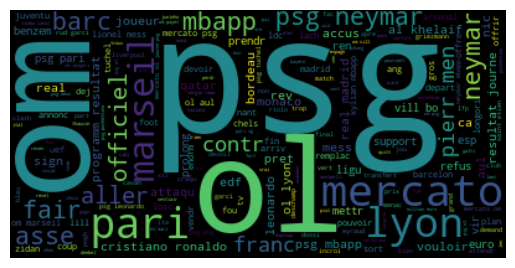

In [402]:
# Create and generate a word cloud image:
text = ' '.join(data[ data['clickbait'] == 1 ] ['headline_tokenized'].apply(lambda x : ' '.join(x)))

wordcloud = WordCloud().generate(text)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

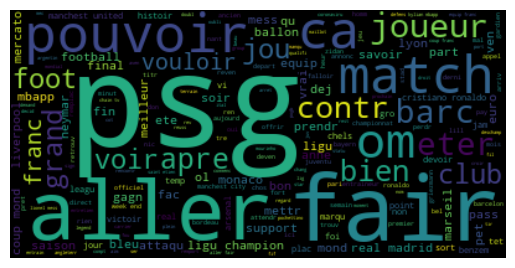

In [403]:
# Create and generate a word cloud image:
text = ' '.join(data[ data['clickbait'] == 0 ] ['headline_tokenized'].apply(lambda x : ' '.join(x)))

wordcloud = WordCloud().generate(text)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

#### TF-IDF

In [405]:
corpus = data['headline_pos_tokenized'].apply(lambda x : ' '.join(x)).values.tolist()
pos_vectorizer = TfidfVectorizer(max_features=1000)
X = pos_vectorizer.fit_transform(corpus)
post_matrix_tfidf = pd.DataFrame.sparse.from_spmatrix(X, columns=pos_vectorizer.get_feature_names_out())
print(f'The shape is post {post_matrix_tfidf.shape}')
post_matrix_tfidf.head(5)

The shape is post (30000, 20)


,adj,adp,adv,aux,cconj,det,intj,loc,misc,noun,num,org,per,pron,propn,punct,sconj,space,sym,verb
0,0.000000,0.000000,0.444964,0.406851,0.000000,0.262456,0.0,0.440680,0.0,0.228127,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.566883
1,0.000000,0.000000,0.000000,0.551639,0.000000,0.177929,0.0,0.000000,0.0,0.154656,0.396483,0.000000,0.000000,0.556833,0.0,0.158620,0.0,0.0,0.0,0.384311
2,0.000000,0.240191,0.000000,0.000000,0.000000,0.000000,0.0,0.378373,0.0,0.000000,0.000000,0.000000,0.722409,0.000000,0.0,0.200894,0.0,0.0,0.0,0.486733
3,0.230269,0.000000,0.000000,0.276433,0.354624,0.178324,0.0,0.598835,0.0,0.464998,0.000000,0.000000,0.000000,0.000000,0.0,0.317945,0.0,0.0,0.0,0.192583
4,0.207367,0.513497,0.000000,0.248939,0.000000,0.160589,0.0,0.269638,0.0,0.418750,0.000000,0.495425,0.000000,0.000000,0.0,0.286323,0.0,0.0,0.0,0.173429


In [406]:
corpus = data['headline_tokenized'].apply(lambda x : ' '.join(x)).values.tolist()
text_vectorizer = TfidfVectorizer()
X_text = text_vectorizer.fit_transform(corpus)
text_matrix_tfidf = pd.DataFrame.sparse.from_spmatrix(X_text, columns=text_vectorizer.get_feature_names_out())
print(f'The shape is post {text_matrix_tfidf.shape}')
text_matrix_tfidf.head(5)

The shape is post (30000, 13994)


,_befootball,_cessk,_dan_austin,_florianmauric,aaaaah,aaaaarmeuh,aannonc,aaron,aballneverl,aballneverli,...,zubizarret,zukanovic,zukztbkc,zumb,zur,zurich,zut,zvonim,zz,zzzzzz
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [408]:
features_sum = text_matrix_tfidf.sum(axis = 0)

In [410]:
features_sum.sort_values(ascending=False)

psg             1081.305216
om               687.472084
ol               612.606586
fair             417.308080
mercato          410.683067
                   ...     
meeeeerd           0.210109
apercoit           0.171104
tintintintin       0.164399
pois               0.098666
combativ           0.098666
Length: 13994, dtype: float64

In [416]:
features_keep = features_sum.sort_values(ascending=False)[:5000].index

In [417]:
# merge the data
data_final = pd.concat( [data, post_matrix_tfidf, text_matrix_tfidf[features_keep]], axis = 1 )

In [418]:
data_final.shape

(30000, 5029)

In [421]:
data_final.to_csv(f'{data_folder}/processed/dataset_good_01.csv', index = False)

In [420]:
1+1

2

In [ ]:
data

In [366]:
px.histogram(data_final, x='verb', color='clickbait')

Some feature have more impact than other

In [376]:
data['have_score'] = data['headline_cleaned'].apply(lambda x : re.search(r'\d(\s*)-(\s*)\d', x) is not None)

In [379]:
data.groupby('clickbait')['have_score'].mean()

clickbait
0    0.020867
1    0.007133
Name: have_score, dtype: float64

Seems very interesting

### Modelisation

In [433]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import  train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score, accuracy_score

In [425]:
train = data_final.drop(columns=['headline', 'headline_cleaned', 'headline_tokenized', 'headline_pos_tokenized'])

train['is_question'] = train['is_question'].astype(int)
train['is_exclamation'] = train['is_exclamation'].astype(int)
train['have_score'] = train['have_score'].astype(int)

In [426]:
# x and y
X, Y = train.drop(columns=['clickbait']), train['clickbait']

In [432]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, train_size=0.2, shuffle=True, random_state=RANDOM_STATE) # train-test

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, shuffle=True, random_state=RANDOM_STATE ) # train-val

In [434]:
model_rf = RandomForestClassifier()
model_rf.fit(x_train, y_train)

C:\Users\avomo\anaconda3\envs\foot_bait_blocker_env\lib\site-packages\sklearn\utils\validation.py:758: UserWarning:

pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.



RandomForestClassifier()

In [448]:
y_pred = model_rf.predict(x_val)
y_pred_proba = model_rf.predict_proba(x_val)[:, 1]
print(accuracy_score(y_val, y_pred))
print(precision_recall_fscore_support(y_true=y_val, y_pred=y_pred))
print(roc_auc_score(y_val, y_pred_proba))

C:\Users\avomo\anaconda3\envs\foot_bait_blocker_env\lib\site-packages\sklearn\utils\validation.py:758: UserWarning:

pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.

C:\Users\avomo\anaconda3\envs\foot_bait_blocker_env\lib\site-packages\sklearn\utils\validation.py:758: UserWarning:

pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.



0.8825
(array([0.89437819, 0.87112561]), array([0.8692053 , 0.89597315]), array([0.88161209, 0.88337469]), array([604, 596], dtype=int64))
0.9504158518156361


In [449]:
y_pred = model_rf.predict(x_test)
y_pred_proba = model_rf.predict_proba(x_test)[:, 1]
print(accuracy_score(y_test, y_pred))
print(precision_recall_fscore_support(y_true=y_test, y_pred=y_pred))
print(roc_auc_score(y_test, y_pred_proba))

C:\Users\avomo\anaconda3\envs\foot_bait_blocker_env\lib\site-packages\sklearn\utils\validation.py:758: UserWarning:

pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.

C:\Users\avomo\anaconda3\envs\foot_bait_blocker_env\lib\site-packages\sklearn\utils\validation.py:758: UserWarning:

pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.



0.8819583333333333
(array([0.90100393, 0.86456756]), array([0.85865225, 0.90534224]), array([0.87931842, 0.88448522]), array([12020, 11980], dtype=int64))
0.9512360103778066


In [450]:
 pd.DataFrame( [model_rf.feature_names_in_, model_rf.feature_importances_]).T.sort_values(by=[1], ascending=False)

,0,1
0,headline_length,0.092628
24,psg,0.048043
19,punct,0.031545
26,ol,0.029848
5,adp,0.029363
...,...,...
3921,selecao,0.0
1889,soulag,0.0
3916,observ,0.0
3915,hospital,0.0


In [453]:
# interesting
fs = open(f'{model_folder}/model_rf.pickle', 'wb')
pickle.dump(model_rf, fs)
fs.close()

In [454]:
fs=open(f'{model_folder}/pos_vectorizer.pickle', 'wb')
pickle.dump(pos_vectorizer, fs)
fs.close()

In [455]:
fs=open(f'{model_folder}/text_vevtorizer.pickle', 'wb')
pickle.dump(text_vectorizer, fs)
fs.close()

In [456]:
fs=open(f'{model_folder}/features_names.pickle', 'wb')
pickle.dump(features_keep, fs)
fs.close()

In [477]:
x_val

,headline_length,is_question,is_exclamation,have_score,adj,adp,adv,aux,cconj,det,...,lucid,flo,river,apparit,cpe,basil,feret,cingl,tar,brand
19165,45,1,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.140158,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15628,74,1,0,0,0.000000,0.233395,0.000000,0.169722,0.000000,0.109486,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7641,46,0,0,0,0.000000,0.179561,0.000000,0.000000,0.335017,0.336930,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7763,70,0,0,0,0.000000,0.172247,0.000000,0.250513,0.000000,0.323207,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20653,69,0,0,0,0.202982,0.335092,0.000000,0.000000,0.000000,0.157193,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13313,60,0,0,0,0.120588,0.000000,0.000000,0.000000,0.000000,0.093386,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8618,48,1,0,0,0.000000,0.395116,0.000000,0.000000,0.368596,0.185350,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
23093,17,0,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.128516,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
27268,155,0,1,0,0.085325,0.281717,0.336078,0.102431,0.131404,0.264308,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


KeyError: 19165

In [468]:
%load_ext autoreload
%autoreload 2

import src.data.preprocess as dp
import importlib
importlib.reload(dp)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<module 'src.data.preprocess' from 'D:\\Projets\\Data Science\\foot_bait_blocker\\src\\data\\preprocess.py'>

In [465]:
df = data.sample(10)

In [470]:

dp.data_handling(df, pos_vectorizer, text_vectorizer, features_keep)

,clickbait,headline_length,is_question,is_exclamation,have_score,adj,adp,adv,aux,cconj,...,lucid,flo,river,apparit,cpe,basil,feret,cingl,tar,brand
10979,1.0,62.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
22882,0.0,136.0,0.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15963,0.0,34.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11087,1.0,35.0,0.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13468,1.0,56.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
29526,0.0,137.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25234,0.0,71.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
24240,0.0,67.0,1.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25967,0.0,183.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
21382,0.0,40.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [471]:
x_train.shape

(4800, 5024)

In [472]:
pd.DataFrame(['howerver'], columns=['headline'])

,headline
0,howerver


In [475]:
len(set(features_keep))

5000

In [476]:
df.columns[df.columns.duplicated()]

Index([], dtype='object')

In [487]:
np.array([3]).tolist()

[3]